<a href="https://colab.research.google.com/github/brianbaert/MscThesis/blob/main/MscThesis_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
!python --version

In [ ]:
#!pip install avalanche_lib[all]
#!pip install gwpy
#!pip install nds2
!pip show avalanche-lib
!pip show gwpy

In [ ]:
 #%cd /content/drive/MyDrive/MscThesis
%pwd

In [74]:
import numpy as np
import os
import pandas as pd
import time

from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.supervised import VAETraining
from avalanche.benchmarks import nc_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix,disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics
import multiprocessing as mp

import my_utils
import my_architectures
import my_dataloaders
import my_gwpy_and_fractals
import my_transformations

IMG_SIZE = (224,224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers/2)
print(number_of_workers)

4


In [3]:
train_dir2 = 'C:\\Users\\Brian.Baert\\TrainingSet'
train_dir = 'C:\\Users\\Brian.Baert\\GravitySpy\\train\\train'
val_dir = 'C:\\Users\\Brian.Baert\\GravitySpy\\validation\\validation'
test_dir = 'C:\\Users\\Brian.Baert\\GravitySpy\\test\\test'

In [4]:
meta_train_v1 = pd.read_csv('C:\\Users\\Brian.Baert\\GravitySpy\\trainingset_v1d1_metadata.csv')
print(meta_train_v1[meta_train_v1['sample_type']=='train']['label'].value_counts())
classes = meta_train_v1['label'].unique()

label
Blip                   1274
Koi_Fish                498
Low_Frequency_Burst     437
Light_Modulation        361
Extremely_Loud          316
Low_Frequency_Lines     315
Power_Line              314
Scattered_Light         308
Violin_Mode             284
Scratchy                237
1080Lines               229
Whistle                 208
Helix                   195
Repeating_Blips         185
No_Glitch               107
Tomte                    73
1400Ripples              59
None_of_the_Above        57
Air_Compressor           41
Chirp                    41
Wandering_Line           29
Paired_Doves             19
Name: count, dtype: int64


In [5]:
classes = my_utils.get_classes_from_dir(train_dir2)
class_to_indx = my_utils.classes_to_indices(classes)
class_to_indx

{'1080Lines': 0,
 '1400Ripples': 1,
 'Air_Compressor': 2,
 'Blip': 3,
 'Chirp': 4,
 'Extremely_Loud': 5,
 'Helix': 6,
 'Koi_Fish': 7,
 'Light_Modulation': 8,
 'Low_Frequency_Burst': 9,
 'Low_Frequency_Lines': 10,
 'None_of_the_Above': 11,
 'No_Glitch': 12,
 'Paired_Doves': 13,
 'Power_Line': 14,
 'Repeating_Blips': 15,
 'Scattered_Light': 16,
 'Scratchy': 17,
 'Tomte': 18,
 'Violin_Mode': 19,
 'Wandering_Line': 20,
 'Whistle': 21}

# DL Baseline

In [ ]:
train_set = my_dataloaders.GravitySpy_1_0_dataset(root=train_dir, cls=classes, transform=transformGray)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)
val_set = my_dataloaders.GravitySpy_1_0_dataset(root=val_dir, cls=classes, transform=transformGray)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=number_of_workers)
test_set = my_dataloaders.GravitySpy_1_0_dataset(root=test_dir, cls=classes, transform=transformGray)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [ ]:
train_set = my_dataloaders.GravitySpy_0_5_dataset(root=train_dir, cls=classes, transform=transformGray)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)
val_set = my_dataloaders.GravitySpy_0_5_dataset(root=val_dir, cls=classes, transform=transformGray)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True)
test_set = my_dataloaders.GravitySpy_0_5_dataset(root=test_dir, cls=classes, transform=transformGray)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [ ]:
print("The training loader contains {} instances, the val loader contains {} instances and the test loader contains {} instances".format(len(train_loader), len(val_loader), len(test_loader)))

In [ ]:
class_counts = train_set.count_class_instances()
class_weights = []
for class_name, count in class_counts.items():
  print(f"{class_name}: {count} instances")
  class_weights.append(1.0/(count/len(train_set)))

print(class_weights)

In [ ]:
# Create Neural Network architecture for finetuning
myNet = my_architectures.BaselineGrayscaleNet_resnet18()
myNet.to(device)
print(myNet)

In [ ]:
# Pytorch Training loop
epoch_test_loss = 0
epoch_test_acc = 0
epoch_test_correct = 0
epoch_test_total = 0
best_vloss = 1_000_000.
avg_loss = 0
last_loss = 0
timestamp = my_utils.get_timestamp()

# Define the loss function and optimizer
criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)
optimizer = Adam(myNet.parameters(), lr=0.001, weight_decay=1e-3) #LR from the study of Tiago Fernandes

# Number of epochs to train for
num_epochs = 10
epoch_number = 0

start = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
  total_correct = 0
  total_samples = 0
  print('EPOCH {}: '.format(epoch_number + 1))
  train_loss = 0.0
  myNet.train(True)

  ## TRAINING ONE EPOCH
  for i, data in enumerate(train_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = myNet(inputs)
    # compute loss and gradient
    loss = criterion(outputs, labels)
    #add part of regularization
    l2_reg = torch.tensor(0.0)
    for param in myNet.parameters():
      if param.requires_grad: #exclude frozen layers
        l2_reg += torch.norm(param, p=2)
    loss += 1e-5 * l2_reg
    #end part of regularization
    loss.backward()
    # adjust learning weights
    optimizer.step()

    # print statistics
    _, predicted = torch.max(outputs, 1)
    train_loss += loss.item()
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)

    if i % 16 == 15:
      last_loss = train_loss / 16
      print('  batch {} loss: {}, acc: {}'.format(i+1, last_loss, 100*total_correct/total_samples))
      tb_x = epoch * len(train_loader) + i + 1
      train_loss=0.
    avg_loss = last_loss

  ## VALIDATION
  running_vloss = 0.0
  myNet.eval()

  # disable gradient computation for validation
  with torch.no_grad():
    for i, vdata in enumerate(val_loader):
      vinputs, vlabels = vdata
      vinputs, vlabels = vinputs.to(device), vlabels.to(device)
      voutputs = myNet(vinputs)
      vloss = criterion(voutputs, vlabels)
      running_vloss += vloss
  avg_vloss = running_vloss / (i+1)
  print('LOSS train {:.4f} valid {:.4f} after {} seconds'.format(avg_loss, avg_vloss, time.time()-start))

  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(myNet.state_dict(), model_path)

  #my_utils.checkpoint(myNet, f"epoch-{epoch}.pth")
  epoch_number += 1

end = time.time()
print('Training finished after ', end-start, ' seconds')

In [ ]:
#save model
#torch.save(myNet.state_dict(), '/content/drive/MyDrive/MscThesis/thesis_baseline_finetune_0_5.pth')
torch.save(myNet.state_dict(), 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_baseline_finetune_0_5.pth')
print("Saved Pytorch Model state to thesis_baseline.pth")

In [ ]:
#myNet.load_state_dict(torch.load('/content/drive/MyDrive/MscThesis/thesis_baseline_finetune_1_0.pth'))
myNet.load_state_dict(torch.load('C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_baseline_finetune_1_0.pth'))

In [ ]:
my_utils.n_test_predictions(myNet, test_loader, classes, 20)

In [ ]:
y_pred_list, y_true_list = my_utils.get_predictions(myNet, test_loader)

In [ ]:
# Generate confusion matrix
from sklearn.metrics import f1_score
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))

# Use seaborn heatmap for visualization
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
figTemp = plt.gcf()
plt.show()
plt.draw()
figTemp.savefig('confusion_matrix_baseline_1_0.png')
plt.close()

In [ ]:
print(f"F1 Score for each class: {f1}")
print(f"The average F1 score is: {f1_score(y_true_list, y_pred_list, average='weighted')}")

In [ ]:
# Create a horizontal bar plot for F1 scores with different colors
plt.figure(figsize=(10,7))
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
plt.barh(np.arange(len(classes)), f1, color=colors, align='center', alpha=0.5)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('F1 Score')
plt.title('F1 Score for Each Class')
figTemp = plt.gcf()
plt.show()
plt.draw()
figTemp.savefig('f1_scores_baseline_1_0.png')
plt.close()

# CL Experiments

## Model, dataloader, benchmark and eval plugin

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = my_architectures.SimpleCNN_224by224(num_classes=22, initial_out_features=22)

In [18]:
train_set = my_dataloaders.GravitySpy_1_0_dataset(root=train_dir2, cls=classes, transform=my_transformations.transformAV_224_Crop)
val_set = my_dataloaders.GravitySpy_1_0_dataset(root=val_dir, cls=classes, transform=my_transformations.transformAV_224)
test_set = my_dataloaders.GravitySpy_1_0_dataset(root=test_dir, cls=classes, transform=my_transformations.transformAV_224)

train_set_av = AvalancheDataset(train_set)
train_loader_av = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

val_set_av = AvalancheDataset(val_set)
val_loader_av = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

test_set_av = AvalancheDataset(test_set)
test_loader_av = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

train_set_av.targets = train_set.labels
test_set_av.targets = test_set.labels
val_set_av.targets = val_set.labels

train_set_av.uniques = list(set(train_set.labels))
test_set_av.uniques = list(set(test_set.labels))
val_set_av.uniques = list(set(val_set.labels))

In [19]:
bm = nc_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=11,
    shuffle=False,
    seed=4123,
    task_labels=False,
    class_ids_from_zero_in_each_exp=False,
)

In [20]:
# DEFINE THE EVALUATION PLUGIN
# The evaluation plugin manages the metrics computation.
# It takes as argument a list of metrics, collectes their results and returns
# them to the strategy it is attached to.

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(experience=True),
    forgetting_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()],
    strict_checks=False,
)

In [21]:
model.to(device)
interactive_logger = InteractiveLogger()
print(model)

SimpleCNN_224by224(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): AdaptiveMaxPool2d(output_size=1)
    (15): Dropout(p=0.25, inplace=False)
  )
  (classifier): Linear(in_features=64, out_features=22, bias=True)
)


In [ ]:
my_utils.plot_first_image(train_loader_av)

In [ ]:
my_utils.plot_first_image(val_loader_av)

In [ ]:
my_utils.plot_first_image(test_loader_av)

## Naive strategy with cross entropy loss and adam

In [22]:
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=1e-2)
criterion = CrossEntropyLoss()

In [23]:
# Naive strategy
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=2, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), EarlyStoppingPlugin(patience=2, val_stream_name='valid')]
)

In [24]:
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.Naive object at 0x000002DAFC84FB80>
Start of experience:  0
Current Classes:  [0, 1]
2
-- >> Start of training phase << --
100%|██████████| 4/4 [00:11<00:00,  2.80s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.9346
	Loss_MB/train_phase/train_stream/Task000 = 1.2280
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.1600
100%|██████████| 4/4 [00:11<00:00,  2.90s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.4602
	Loss_MB/train_phase/train_stream/Task000 = 0.5045
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5300
-- >> End of training phase << --
Training completed
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 1.1575
	Time_Exp/eval_phase/train_stream/Ta

In [25]:
#save model
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_Naive_CL_1_0.pth')

Saved Pytorch model state to  C:\Users\Brian.Baert\Documents\GitHub\MscThesis\Models\thesis_Naive_CL_1_0.pth


In [26]:
my_utils.n_test_predictions(model, test_loader_av, classes, 20)

Predicted: "Blip", Actual: "Violin_Mode"
Predicted: "Blip", Actual: "Helix"
Predicted: "Blip", Actual: "1080Lines"
Predicted: "Blip", Actual: "Extremely_Loud"
Predicted: "Blip", Actual: "Scratchy"
Predicted: "Blip", Actual: "Blip"
Predicted: "Blip", Actual: "Whistle"
Predicted: "Blip", Actual: "Light_Modulation"
Predicted: "Blip", Actual: "Violin_Mode"
Predicted: "Blip", Actual: "Power_Line"
Predicted: "Blip", Actual: "Blip"
Predicted: "Blip", Actual: "Low_Frequency_Burst"
Predicted: "Blip", Actual: "Koi_Fish"
Predicted: "Blip", Actual: "Extremely_Loud"
Predicted: "Blip", Actual: "Blip"
Predicted: "Blip", Actual: "Violin_Mode"
Predicted: "Blip", Actual: "Low_Frequency_Burst"
Predicted: "Blip", Actual: "Blip"
Predicted: "Blip", Actual: "Light_Modulation"
Predicted: "Blip", Actual: "Low_Frequency_Lines"
n_test_predictions: 1353.9350032806396 ms


In [27]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

get_predictions: 73282.59682655334 ms


In [28]:
# Generate confusion matrix
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

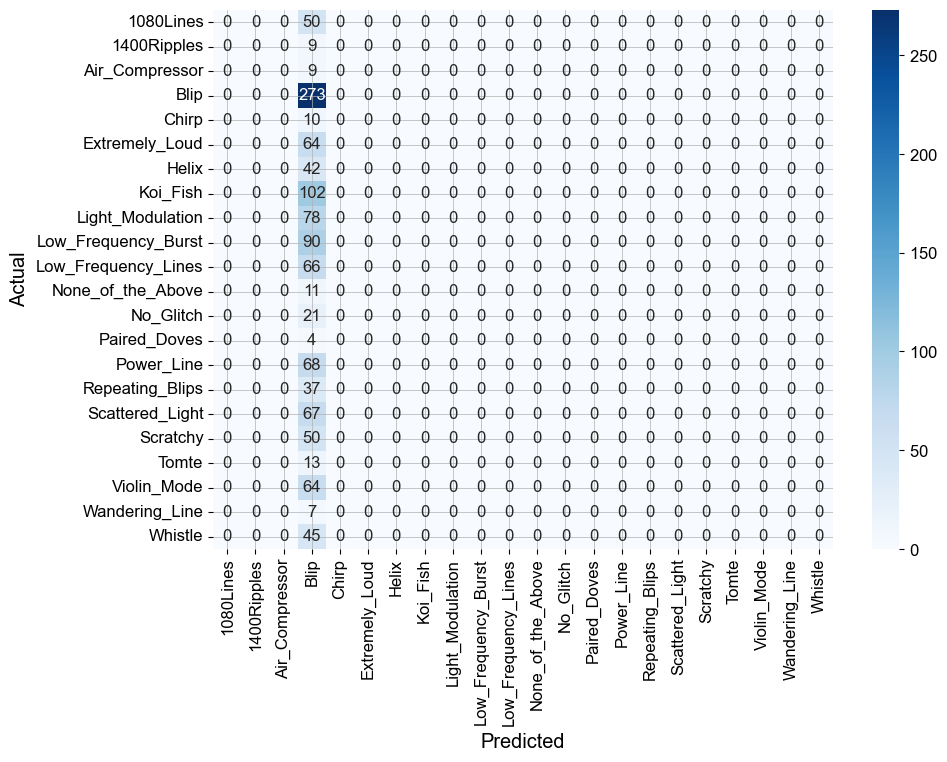

In [29]:
my_utils.plot_confusion_matrix(cm, classes, 'cm_Naive_1_0.png')

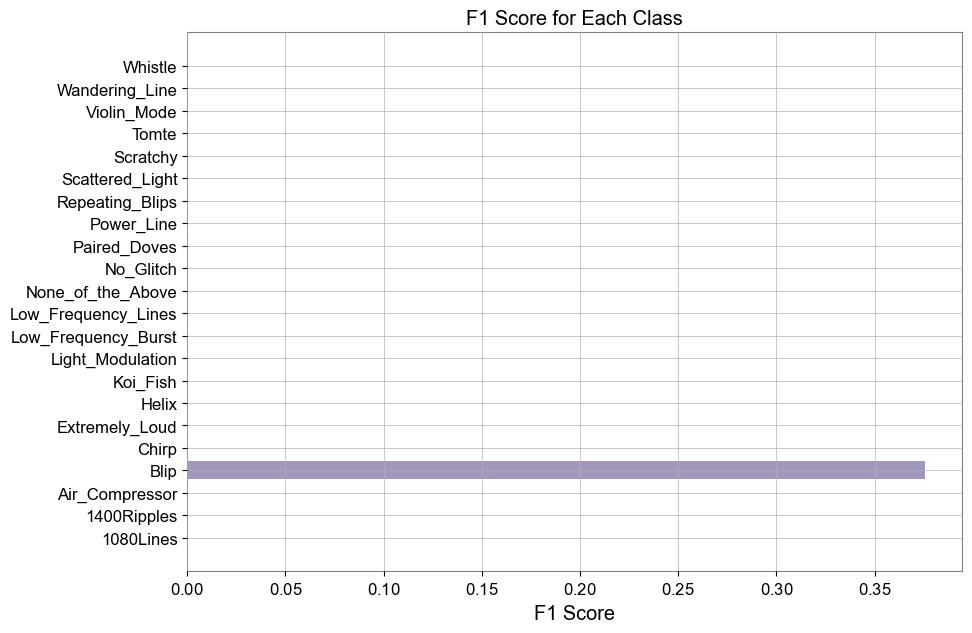

In [30]:
my_utils.plot_f1_scores(f1, classes, 'f1_scores_Naive_1_0.png')

## LwF strategy with cross entropy loss and adam optimizer
The experiments are done on a neural network starting with 2 output nodes and gradually adapting with each experience to 22, but also on a neural network with 22 output nodes and running over the experiences.

In [31]:
model = my_architectures.SimpleCNN_224by224(num_classes=22, initial_out_features=22)
model.to(device)
interactive_logger = InteractiveLogger()
print(model)

SimpleCNN_224by224(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): AdaptiveMaxPool2d(output_size=1)
    (15): Dropout(p=0.25, inplace=False)
  )
  (classifier): Linear(in_features=64, out_features=22, bias=True)
)


In [32]:
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=1e-2)
criterion = CrossEntropyLoss()

In [33]:
#alpha and temperature are taken from the paper by Oren & Wolf - "In defense of the Learning Without Forgetting for Task Incremental Learning"
cl_strategy = LwF(
    model=model, optimizer=optimizer, criterion=criterion, alpha=0.25, temperature=2.0, 
    train_mb_size=64, train_epochs=2, eval_mb_size=32, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set))] #Early stopping is not used here because LwF does not inherently support Early Stopping
)

In [35]:
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.LwF object at 0x000002DB7605C7F0>
Start of experience:  0
Current Classes:  [0, 1]
2
-- >> Start of training phase << --
100%|██████████| 2/2 [00:10<00:00,  5.18s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 3.1163
	Loss_MB/train_phase/train_stream/Task000 = 3.0464
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
100%|██████████| 2/2 [00:11<00:00,  5.64s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.3994
	Loss_MB/train_phase/train_stream/Task000 = 1.6779
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4600
-- >> End of training phase << --
Training completed
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 4/4 [00:05<00:00,  1.36s/it]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 0.7527
	Time_Exp/eval_phase/train_stream/Task

In [36]:
#save model
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_LwF_CL_1_0.pth')

Saved Pytorch model state to  C:\Users\Brian.Baert\Documents\GitHub\MscThesis\Models\thesis_LwF_CL_1_0.pth


In [37]:
#calculate predictions
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

get_predictions: 82543.84160041809 ms


In [38]:
# Generate confusion matrix
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

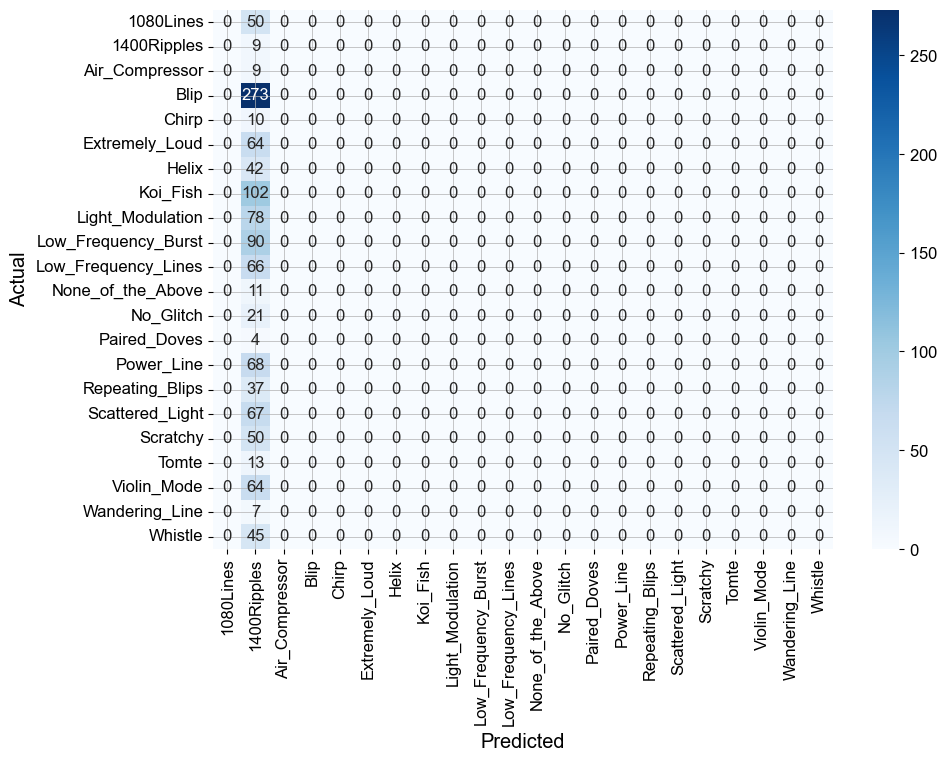

In [39]:
my_utils.plot_confusion_matrix(cm, classes, 'cm_LwF_1_0.png')

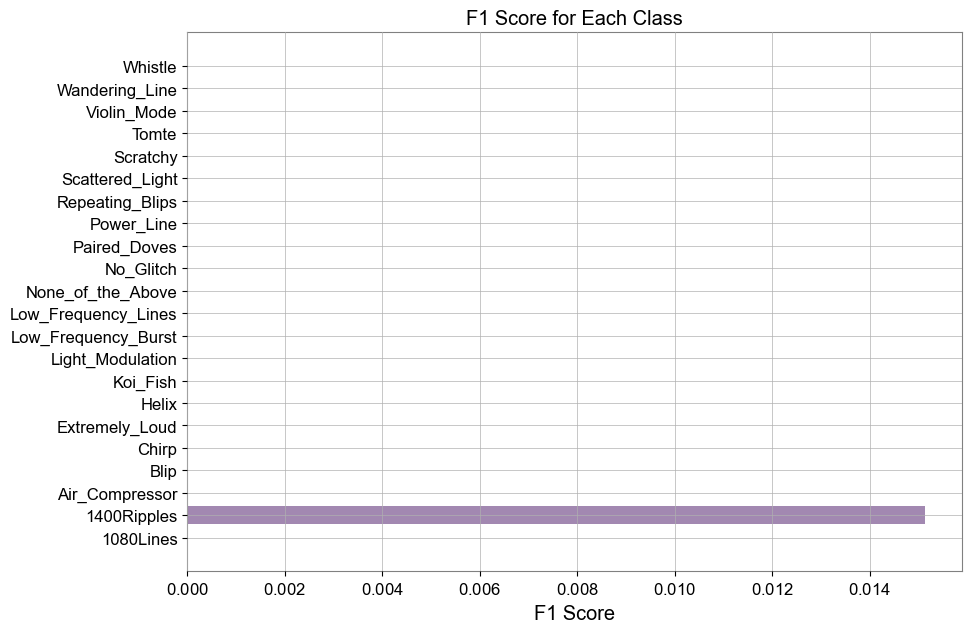

In [40]:
my_utils.plot_f1_scores(f1, classes, 'f1_scores_LwF_1_0.png')

## LFL (Less Forgetful Learning) strategy with cross entropy loss and adam optimizer

In [ ]:
model = my_architectures.MLP(initial_out_features=22)
model.to(device)
interactive_logger = InteractiveLogger()
print(model)

In [ ]:
optimizer = SGD(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()
lambda_e = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]

In [ ]:
cl_strategy = LFL(
    model=model, optimizer=optimizer, criterion=criterion, lambda_e=lambda_e, 
    train_mb_size=64, train_epochs=3, eval_mb_size=32, device=device, evaluator=eval_plugin
)

In [ ]:
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers)

In [ ]:
#save model
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_LFL_CL_1_0.pth')

In [ ]:
#calculate predictions
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
my_utils.plot_confusion_matrix(cm, classes, 'cm_LFL_1_0.png')

In [ ]:
my_utils.plot_f1_scores(f1, classes, 'f1_scores_LFL_1_0.png')

## AGEM strategy with cross entropy loss and adam

In [75]:
model = my_architectures.SimpleCNN_224by224(num_classes=22, initial_out_features=2)
model.to(device)
interactive_logger = InteractiveLogger()

In [76]:
optimizer = SGD(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()

In [80]:
cl_strategy = AGEM(
    model=model, optimizer=optimizer, criterion=criterion, patterns_per_exp=2,
    train_mb_size=64, train_epochs=1, eval_mb_size=32, device=device, evaluator=eval_plugin,
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), AGEMPlugin(patterns_per_experience=2, sample_size=22)]
)

In [ ]:
results=[]
results = my_utils.cl_adaptive_train_loop(bm, cl_strategy, model, optimizer, number_of_workers)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.AGEM object at 0x000002DAA70A3280>
Start of experience:  0
Current Classes:  [0, 1]
2
-- >> Start of training phase << --
100%|██████████| 2/2 [00:10<00:00,  5.38s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6977
	Loss_MB/train_phase/train_stream/Task000 = 0.7065
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5000
-- >> End of training phase << --
Training completed
Learning rate adjusted to  0.011
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 4/4 [00:04<00:00,  1.19s/it]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 0.6951
	Time_Exp/eval_phase/train_stream/Task000/Exp000 = 4.7461
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.5000
-- >> End of eval phase << --
	Loss_Stream/eval_phase/train_stream/Task000 = 0.6951
	StreamForgetting/eval_p

In [67]:
#save model
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_AGEM_CL_1_0.pth')

Saved Pytorch model state to  C:\Users\Brian.Baert\Documents\GitHub\MscThesis\Models\thesis_AGEM_CL_1_0.pth


In [68]:
#calculate predictions
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

get_predictions: 70935.78791618347 ms


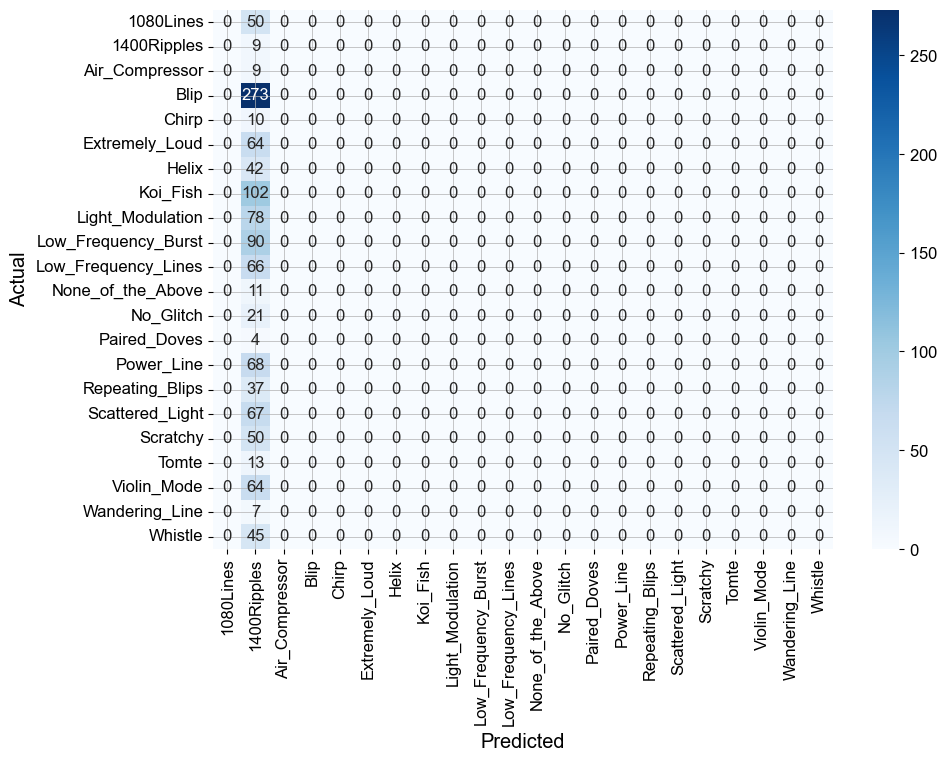

In [69]:
my_utils.plot_confusion_matrix(cm, classes, 'cm_adaptive_AGEM_1_0.png')

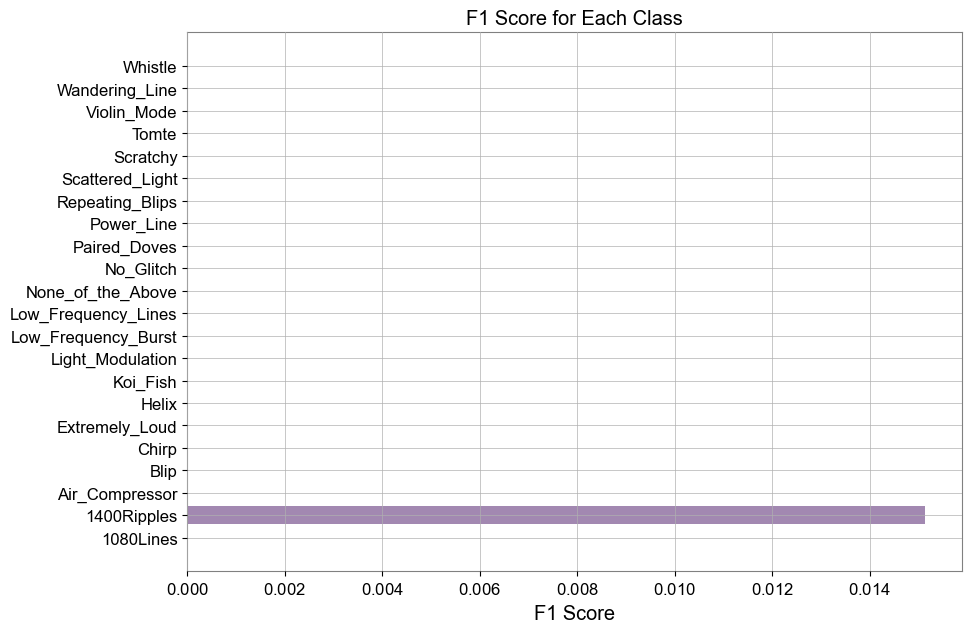

In [70]:
my_utils.plot_f1_scores(f1, classes, 'f1_adaptive_AGEM_1_0.png')